# Question 4

### 4. Implementing Matrix Factorization [6 Marks]

Use the [instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/movie-recommendation-knn-mf.ipynb) on matrix factorisation, and solve the following questions.

**a) Image Reconstruction-** Here, ground truth pixel values are missing for particular regions within the image- you don't have access to them.

- **[2 Marks]** Use an image and reconstruct the image in the following two cases, where your region is-
    1. a rectangular block of 30X30 is assumed missing from the image.
    2. a random subset of 900 (30X30) pixels is missing from the image.

    Choose rank `r` yourself. Perform Gradient Descent till convergence, plot the selected regions, original and reconstructed images, Compute the following metrics:
    * RMSE on predicted v/s ground truth high resolution image
    * Peak SNR

    
- **[2 Marks]** Write a function using this [reference](https://pytorch.org/docs/stable/generated/torch.linalg.lstsq.html) and use alternating least squares instead of gradient descent to repeat Part 1, 2 of Image reconstruction problem using your written function.

In [ ]:
!pip install torchmetrics --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.image import PeakSignalNoiseRatio

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
import os
if os.path.exists('shrek.jpg'):
    print('shrek.jpg exists')
else:
    !wget "https://static.voices.com/wp-content/uploads/2025/01/shrek-scaled.jpg" -O "shrek.jpg"

--2025-10-13 17:24:09--  https://static.voices.com/wp-content/uploads/2025/01/shrek-scaled.jpg
Resolving static.voices.com (static.voices.com)... 104.18.16.169, 104.18.17.169, 2606:4700::6812:10a9, ...
Connecting to static.voices.com (static.voices.com)|104.18.16.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 436590 (426K) [image/jpeg]
Saving to: ‘shrek.jpg’

shrek.jpg           100%[===================>] 426.36K  --.-KB/s    in 0.02s   

2025-10-13 17:24:09 (22.8 MB/s) - ‘shrek.jpg’ saved [436590/436590]



In [ ]:
import torchvision
img = torchvision.io.read_image("shrek.jpg")
print(img.shape)

torch.Size([3, 1440, 2560])


/tmp/ipython-input-3429424475.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


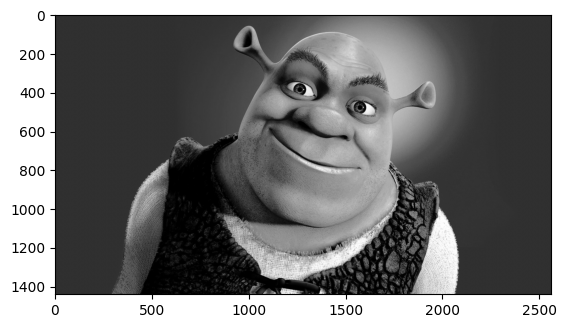

In [ ]:
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
plt.imshow(img, cmap='gray')

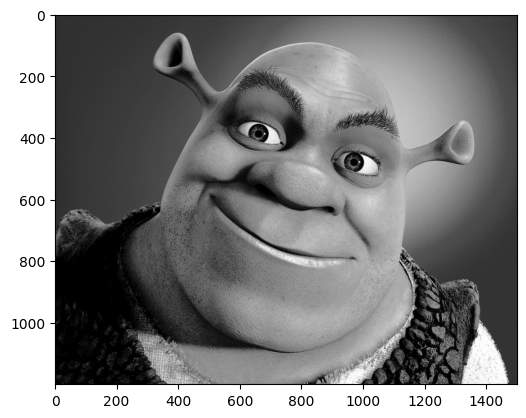

In [ ]:
crop = torchvision.transforms.functional.crop(img, 0, 600, 1200, 1500)
crop.shape
plt.imshow(crop, cmap='gray')

In [ ]:
def mask_block(img, x, y, block_size):
    img_copy = img.clone()
    img_copy[x:x+block_size, y:y+block_size] = float('nan')
    return img_copy

def mask_random_subset(img, num_pixels):
    img_copy = img.clone()
    H, W = img.shape
    rows = torch.randint(0, H, (num_pixels, ))
    cols = torch.randint(0, W, (num_pixels, ))
    img_copy[rows, cols] = float('nan')
    return img_copy

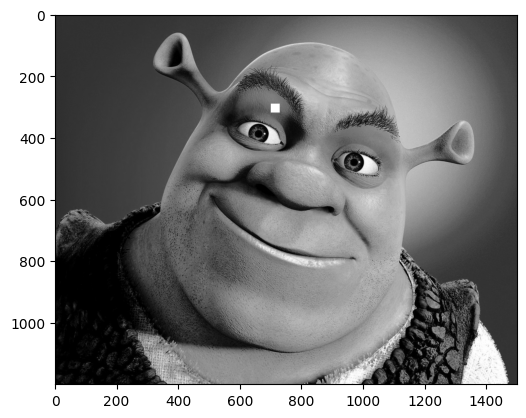

In [ ]:
block_masked_img = mask_block(crop, 290, 700, 30)
plt.imshow(block_masked_img, cmap="gray")

In order to make the effect of image reconstruction more visible, I decided to mask 500,000 pixels from the cropped image (instead of 900) which is very less for my image.

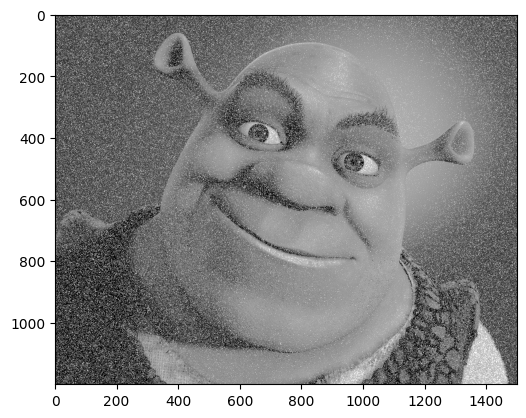

In [ ]:
random_masked_img = mask_random_subset(crop, 500000)
plt.imshow(random_masked_img, cmap="gray")

In [ ]:
def compute_rmse(reconstructed, original):
  m, n = original.shape
  rmse = 0
  for i in range(m):
    for j in range(n):
      rmse += (original[i][j] - reconstructed[i][j])**2
  rmse /= (m*n)
  rmse = torch.sqrt(rmse)
  return rmse

def compute_psnr(reconstructed, original):
  psnr_metric = PeakSignalNoiseRatio(data_range=255.0)
  psnr_metric.update(reconstructed, original)
  psnr_value = psnr_metric.compute()
  return psnr_value.item()

In [ ]:
def plot_images_for_different_k(masked_img, original_img, k_values, factorization_func, device=torch.device("cpu")):
  images = [original_img, masked_img]
  rmse_values = []
  psnr_values = []

  for k in k_values:
      W, H, loss = factorization_func(masked_img, k, device)
      reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
      images.append(reconstructed_img)
      rmse = compute_rmse(reconstructed_img, original_img)
      psnr = compute_psnr(torch.from_numpy(reconstructed_img), original_img)
      rmse_values.append(rmse)
      psnr_values.append(psnr)

  ncols = len(images)
  fig, axes = plt.subplots(1, ncols, figsize=(3 * ncols, 3))
  titles = ["Original", "Masked Image"] + [f"k={k} (RMSE:{rmse:.2f} PSNR: {psnr:.2f} dB)" for k,rmse, psnr in zip(k_values, rmse_values, psnr_values)]
  for ax, img, title in zip(axes, images, titles):
      ax.imshow(img, cmap='gray')
      ax.set_title(title)
      ax.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def factorize_with_SGD(A, k, device=torch.device("cpu"), lr=0.01, tol=1e-6, max_iter=10000):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.SGD([W, H], lr=lr)
    mask = ~torch.isnan(A)

    prev_loss = float('inf')
    for i in range(max_iter):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check convergence
        loss_val = loss.item()
        if abs(prev_loss - loss_val) < tol:
            break
        prev_loss = loss_val

    return W, H, loss

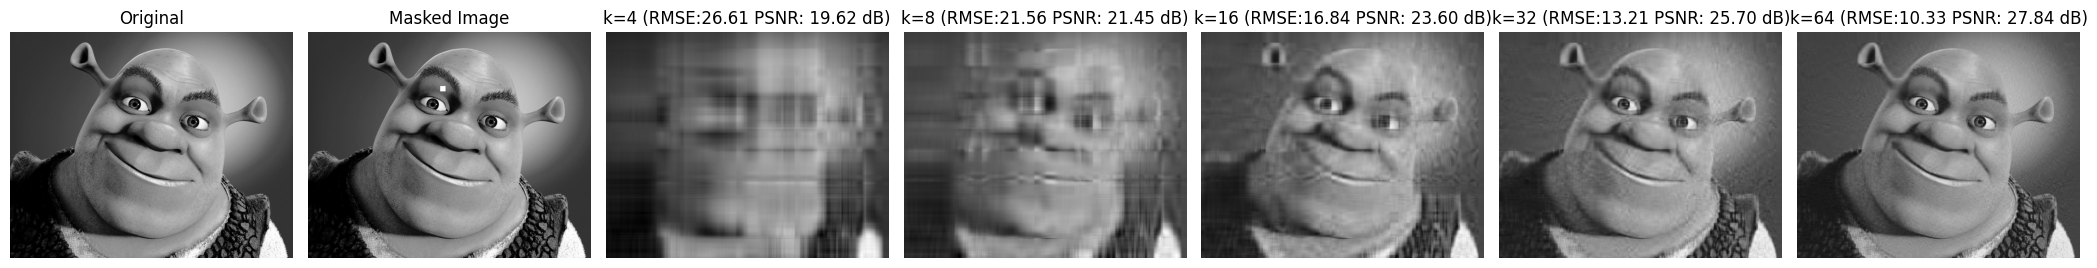

In [ ]:
k_values = [4,8,16,32,64]
plot_images_for_different_k(block_masked_img, crop, k_values, factorize_with_SGD, device)

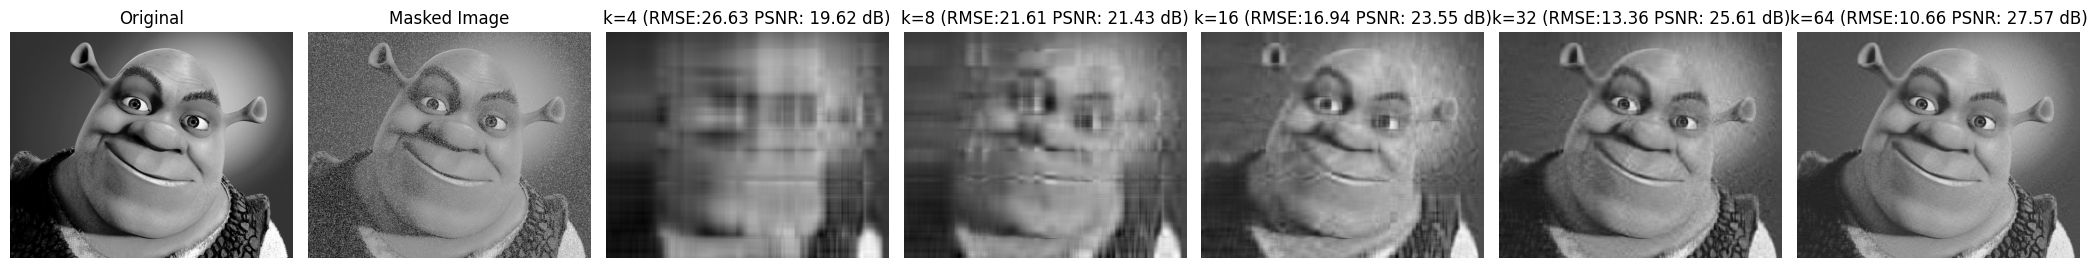

In [ ]:
k_values = [4,8,16,32,64]
plot_images_for_different_k(random_masked_img, crop, k_values, factorize_with_SGD, device)

In [ ]:
def factorize_with_ALS(A, k, device = torch.device("cpu"), tol=1e-6, max_iter = 10000):
    A = A.to(device)
    mask = ~torch.isnan(A)
    m, n = A.shape
    W = torch.randn(m, k, requires_grad=False, device=device)
    H = torch.randn(k, n, requires_grad=False, device=device)
    prev_loss = float("inf")

    for it in range(max_iter):
        for j in range(n):
            obs_rows = mask[:, j]
            if obs_rows.sum() == 0:
                continue
            W_obs = W[obs_rows, :] # A = WH -> 5x1 = (5xk).(kx1) -> H = LS(W, A)
            A_obs = A[obs_rows, j]
            H[:, j] = torch.linalg.lstsq(W_obs, A_obs).solution

        for i in range(m):
            obs_cols = mask[i, :]
            if obs_cols.sum() == 0:
                continue
            H_obs = H[:, obs_cols].T
            A_obs = A[i, obs_cols]
            W[i, :] = torch.linalg.lstsq(H_obs, A_obs).solution

        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss

    return W, H, loss

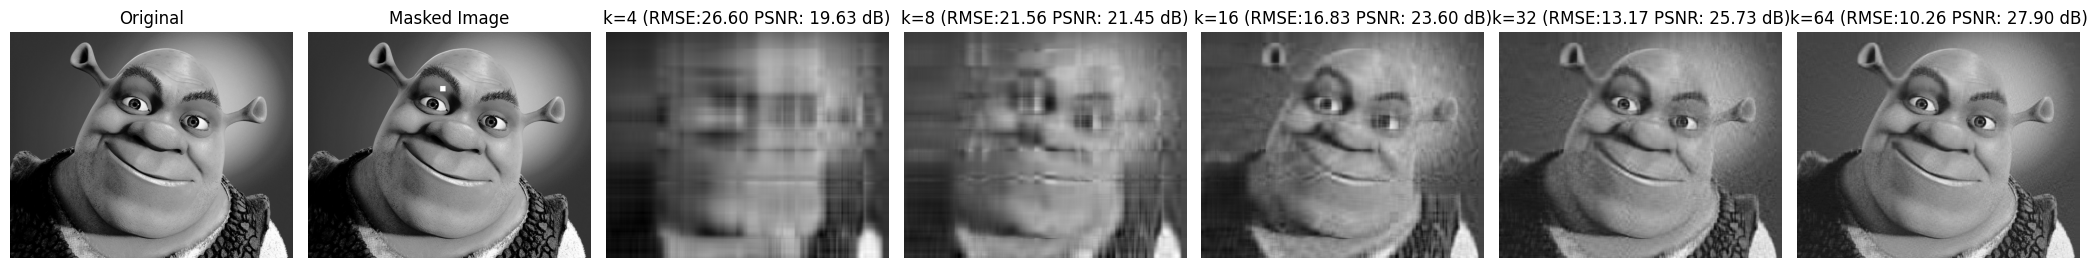

In [ ]:
k_values = [4, 8, 16, 32, 64]
plot_images_for_different_k(block_masked_img, crop,  k_values, factorize_with_ALS, device)

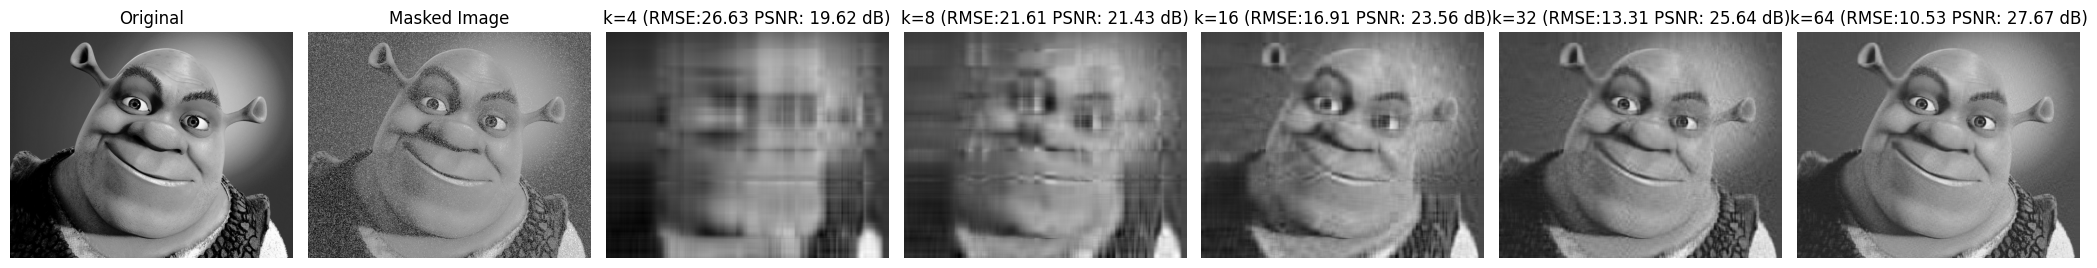

In [ ]:
k_values = [4, 8, 16, 32, 64]
plot_images_for_different_k(random_masked_img, crop, k_values, factorize_with_ALS, device)

**b) Data Compression-** Here, ground truth pixel values are not missing- you have access to them. You want to explore the use of matrix factorisation in order to store them more efficiently.
- **[2 Marks]** Consider an image patch of size (NxN) where N=50. We are trying to compress this patch (matrix) into two matrices, by using low-rank matrix factorization. Consider the following three cases-
    1. a patch with mainly a single color.
    2. a patch with 2-3 different colors.
    3. a patch with at least 5 different colors.

    Vary the low-rank value as ```r = [5, 10, 25, 50]```  for each of the cases. Use Gradient Descent and plot the reconstructed patches over the original image (retaining all pixel values outside the patch, and using your learnt compressed matrix in place of the patch) to demonstrate difference in reconstruction quality. Write your observations.

In [1]:
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2025-10-14 07:24:48--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.65.39.29, 18.65.39.54, 18.65.39.48, ...
Connecting to segment-anything.com (segment-anything.com)|18.65.39.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.01s   

2025-10-14 07:24:49 (20.5 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [ ]:
import torchvision
img = torchvision.io.read_image("images/dog.jpg")
img = torch.tensor(img, dtype=torch.float)
gray = img.mean(dim=0, keepdim=False)
print(gray.shape)

RuntimeError: [Errno 2] No such file or directory: 'dog.jpg'

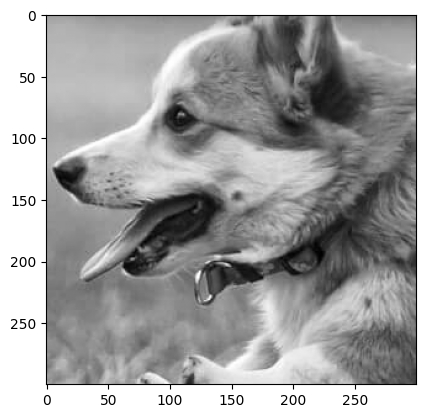

In [4]:
# plt.imshow(gray, cmap='gray')
dog = torchvision.transforms.functional.crop(gray, 600, 800, 300, 300)
plt.imshow(dog, cmap='gray')

In [ ]:
positions = [[0,0],[60,10], [170,100]]
patches = []
for pos in positions:
    patch = torchvision.transforms.functional.crop(dog, pos[0], pos[1], 50, 50)
    patches.append(patch)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
patch_colors = ["single color", "two colors", "multi colors"]
for i, (patch, color) in enumerate(zip(patches, patch_colors)):
    axes[i].imshow(patch, cmap='gray')
    axes[i].set_title(color)
    axes[i].axis('off')

# for patch in patches:
#     plt.imshow(patch, cmap = "gray")
#     plt.show()

In [6]:
def factorize_with_Adam(A, k, device=torch.device("cpu"), max_iter=10000):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    for i in range(max_iter):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return W, H, loss

In [7]:
r = [5, 10, 25, 50]

losses = []
factors = []
for patch in patches:
    losses_ = []
    factors_ = []
    for k in r:
        W_, H_, loss_ = factorize_with_Adam(patch,k, max_iter=1000)
        factors_.append((W_, H_))
        losses_.append(loss_.detach().numpy())
    losses.append(losses_)
    factors.append(factors_)

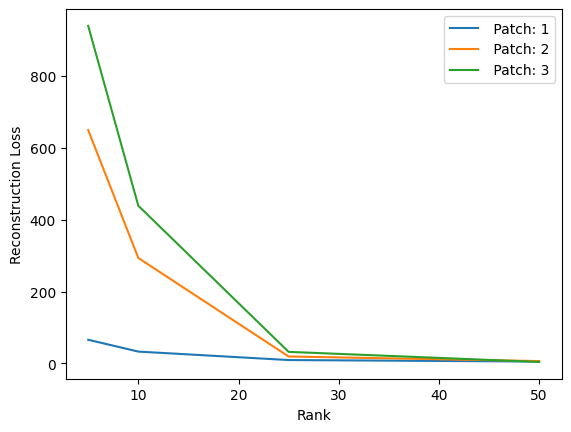

In [9]:
for loss in losses:
    plt.plot(r, loss, label = f" Patch: {losses.index(loss)+ 1}")

plt.xlabel("Rank")
plt.ylabel("Reconstruction Loss")
plt.legend()
plt.show()
# losses

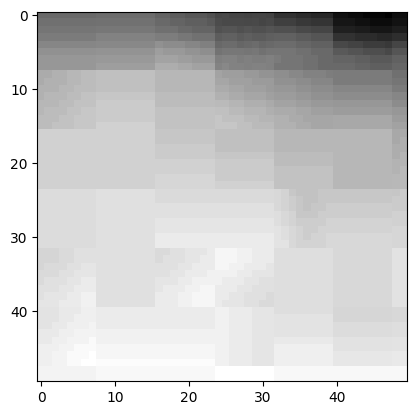

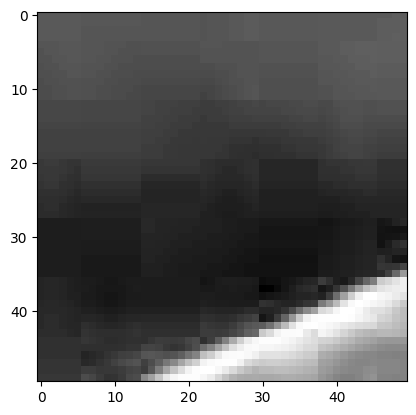

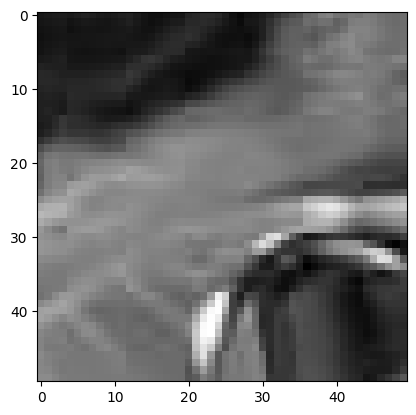

In [ ]:
fig, axes = plt.subplots(3, len(r) + 2, figsize=(16, 8))

for i, (pos, patch, facs) in enumerate(zip(positions, patches, factors)):
    axes[i, 0].imshow(dog, cmap='gray')
    rect = plt.Rectangle((pos[1], pos[0]), 50, 50, edgecolor='red', facecolor='none', linewidth=2)
    axes[i, 0].add_patch(rect)
    axes[i, 0].set_title(f'Patch {i+1} location')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(patch, cmap='gray')
    axes[i, 1].set_title('Original patch')
    axes[i, 1].axis('off')

    for j, (k, (W, H)) in enumerate(zip(r, facs)):
        recon = torch.matmul(W, H).detach()
        axes[i, j + 2].imshow(recon, cmap='gray')
        axes[i, j + 2].set_title(f'k={k}')
        axes[i, j + 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, len(r) + 2, figsize=(16, 8))

for i, (pos, patch, facs) in enumerate(zip(positions, patches, factors)):
    y, x = pos  # clarify coordinate meaning
    patch_size = 50

    axes[i, 0].imshow(dog, cmap='gray')
    rect = plt.Rectangle((x, y), patch_size, patch_size,
                         edgecolor='red', facecolor='none', linewidth=2)
    axes[i, 0].add_patch(rect)
    axes[i, 0].set_title(f'Patch {i+1} location')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(patch, cmap='gray')
    axes[i, 1].set_title('Original patch')
    axes[i, 1].axis('off')

    for j, (k, (W, H)) in enumerate(zip(r, facs)):
        recon = torch.matmul(W, H).detach()

        dog_ = dog.clone()
        dog_[y:y + patch_size, x:x + patch_size] = recon

        axes[i, j + 2].imshow(dog_, cmap='gray')
        axes[i, j + 2].set_title(f'k={k}')
        axes[i, j + 2].axis('off')

plt.tight_layout()
plt.show()


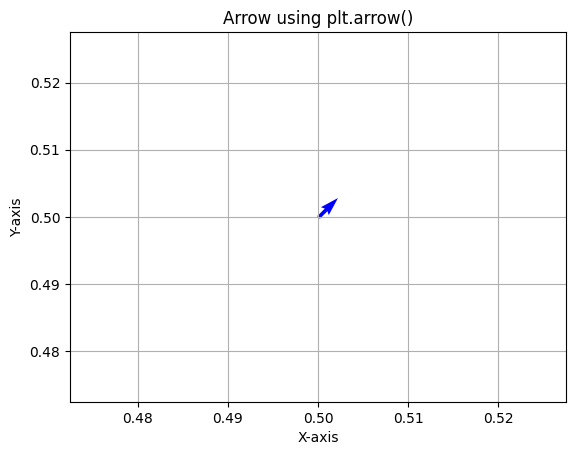

In [ ]:
# plt.figure()
# # plt.plot([0, 1, 2], [0, 1, 0]) # Example line
# plt.quiver(0.5, 0.5, 0.2, 0.2,  fc='blue', ec='blue')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Arrow using plt.arrow()')
# plt.grid(True)
# plt.show()